# Titanic
 - wikidocs, https://wikidocs.net/75068
 

## 데이터 분석
 - 데이터셋의 칼럼, 데이터 내용 확인
 - 칼럼과 생존률의 관계 확인

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 결측치 확인
 데이터 이상 여부 확인하기 위해 결측치 확인한다.
 결측치, 이상치는 분석 결과 왜곡시킬 수 있기때문에

In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

> Cabin의 경우 전체 데이터 건수에 비해 많은 값들이 비어 있으므로 (891/687) 분석 대상에서 제외해도 될 것이나, 
  분석 연습을 위해 적절한 값으로 채운 후 전처리 실행

 ### 분석용 차트 생성 함수
 생존 여부(Survived)와 각 칼럼 간 관계를 파이 차트로 분석하기 위해 공통 함수를 아래와 같이 구현
 - show_pie_chart
   - survived_crosstab, pir_chart 함수를 이용해 파이차트 생성

 - survived_crosstab 
   - col_name과 Survived 간의 교차 도표 생성
   - 생존 여부를 보기 편하게 문자로 변환
   
 - pie_chart
   - 파이 차트 생성

In [4]:
def show_pie_chart(df, col_name):
    colname_survived = survived_crosstab(train, col_name)
    pie_chart(colname_survived)
    return colname_survived

def survived_crosstab(df, col_name):
    '''col_name과 Survived간의 교차도표 생성'''
    feature_survived = pd.crosstab(df[col_name], df['Survived'])
    feature_survived.columns = feature_survived.columns.map({0:"Dead", 1:"Alive"})
    return feature_survived

def pie_chart(feature_survived):
    '''
    pie_cahrt 생성
    pcol, prow = 차트를 출력할 개수, pcol * prow 만큼의 차트 출력
    '''
    frows, fcol = feature_survived.shape
    pcol = 3
    prow = (frows/pcol + frows%pcol)
    plot_height = prow * 2.5
    plt.figure(figsize=(8,plot_height))
    
    for row in range(0,frows):
        plt.subplot(prow, pcol, row+1)
        
        index_name = feature_survived.index[row]
        plt.pie(feature_survived.loc[index_name], labels = feature_survived.loc[index_name].index, autopct='%1.1f%%')
        plt.title("{0}' survived".format(index_name))
    
    plt.show()

### Sex
 - 성별과 생존률의 관계 확인
   > 남성에 비해 여성의 생존률이 높다

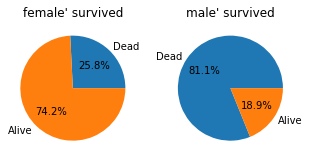

Survived,Dead,Alive
Sex,,
female,81,233
male,468,109


In [5]:
c = show_pie_chart(train, 'Sex')
c

### Embarked
 - 승선위치에 따른 생존률 확인.
 > C > Q> S 순으로 생존률 높음

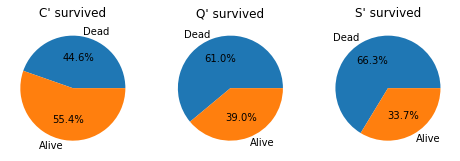

In [6]:
c = show_pie_chart(train, 'Embarked')

### Name
 - 이름에서 호칭 추출
 - 추출한 데이터에서 빈도가 많은 Mr, Miss, Mrs, Master 유지
 - 나머지는 Other로 변경, 프랑스 호칭 변경

In [7]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.')
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Jonkheer      1
Lady          1
Don           1
Countess      1
Capt          1
Sir           1
Ms            1
Mme           1
Name: Title, dtype: int64

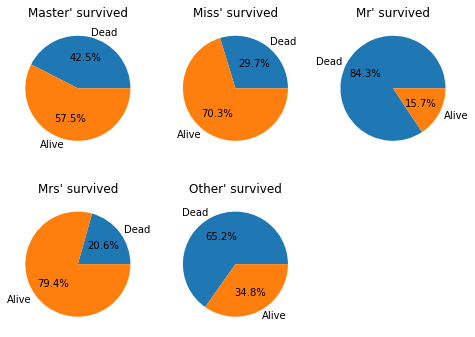

Survived,Dead,Alive
Title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Other,15,8


In [8]:
train['Title'] = train['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Other')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
train['Title'] = train['Title'].replace('Ms', 'Miss')

train['Title'].value_counts()

c = show_pie_chart(train, 'Title')
c

> 생존률 비교시 Miss, Mrs에 비해 Mr의 생존률이 낮다.

### Age
나이와 생존률의 관계 확인. 나이에 존재하는 결측치를 호칭과 나이로 구한 나이의 평균값으로 채운다.
나이를 qcut을 이용해 8개의 구간으로 분리해 나이 카테고리(AgeCategory)로 만든다

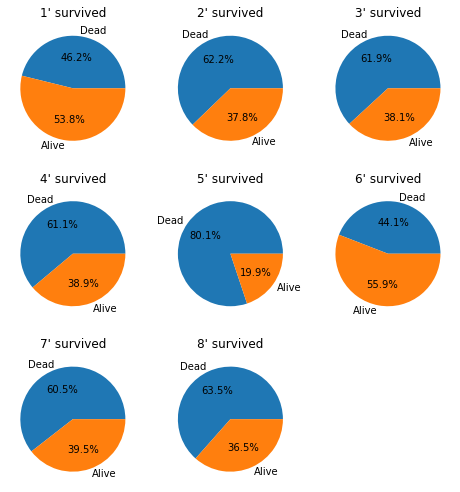

Survived,Dead,Alive
AgeCategory,,
1,54,63
2,79,48
3,60,37
4,66,42
5,125,31
6,30,38
7,69,45
8,66,38


In [9]:
meanAge = train[['Title', 'Age']].groupby(['Title']).mean()

for index, row in meanAge.iterrows():
    nullIndex = train[(train.Title == index) & (train.Age.isnull())].index
    train.loc[nullIndex, 'Age'] = row[0]
    
train['AgeCategory'] = pd.qcut(train.Age, 8, labels = range(1,9))
train.AgeCategory = train.AgeCategory.astype(int)

c = show_pie_chart(train, 'AgeCategory')
c

> 어릴수록 생존률이 상승하고, 결측치가 많이 포함된 데이터는 생존률 저하

### Cabin
방 번호와 생존률의 관계 확인. <br>
방 번호의 결측치는 N으로 치환, 방 번호의 첫 영문자만 떼어낸 뒤 숫자로 범주화

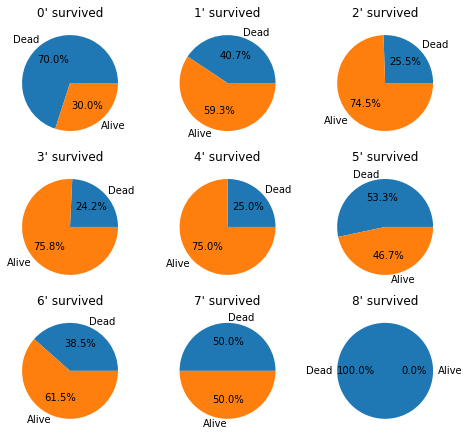

Survived,Dead,Alive
CabinCategory,,
0,481,206
1,24,35
2,12,35
3,8,25
4,8,24
5,8,7
6,5,8
7,2,2
8,1,0


In [10]:
train.Cabin.fillna('N', inplace = True)

train['CabinCategory'] = train['Cabin'].str.slice(start=0, stop=1)
train['CabinCategory'] = train['CabinCategory'].map({ "N": 0, "C": 1, "B": 2, "D": 3, "E": 4, "A": 5, "F": 6, "G": 7, "T": 8 })

c = show_pie_chart(train, 'CabinCategory')
c

> 방 번호 낮아질수록 생존률 저하

### Fare
운임과 생존률의 관계 확인. <br>
운임의 결측치는 0으로 채우고 qcut을 이용해 8개의 구간으로 분리하여 범주화.

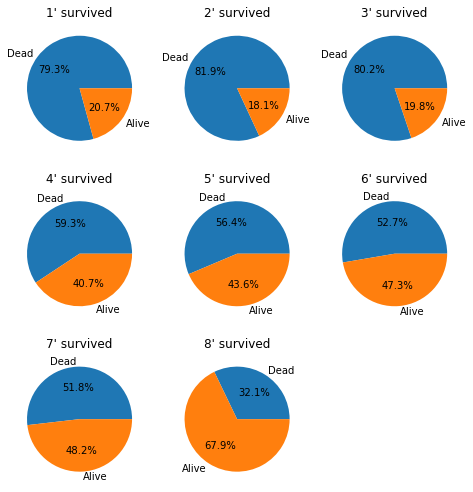

Survived,Dead,Alive
FareCategory,,
1,111,29
2,68,15
3,89,22
4,67,46
5,62,48
6,59,53
7,57,53
8,36,76


In [11]:
train.Fare.fillna(0) # test.csv 데이터에 결측치 존재
train['FareCategory'] = pd.qcut(train.Fare, 8, labels = range(1,9))
train.FareCategory = train.FareCategory.astype(int)

c = show_pie_chart(train, 'FareCategory')
c

### SibSp, Parch
1. 형제/자매 여부와 부모/자식 여부는 모두 더해서 가족의 숫자로 표현
2. 혼자 여부 표현하는 IsAlone 변수 생성

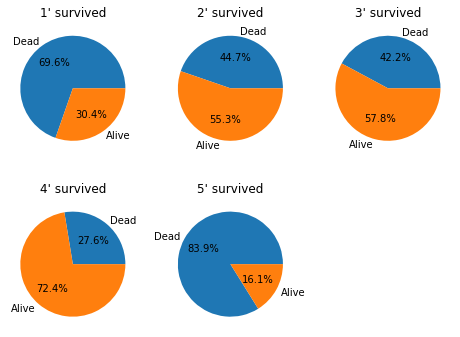

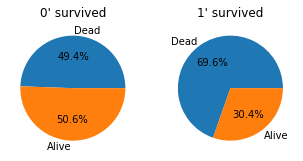

Survived,Dead,Alive
IsAlone,,
0,175,179
1,374,163


In [12]:
train['Family'] = train['SibSp'] + train['Parch'] + 1
train.loc[train['Family'] > 4, 'Family'] = 5

train['IsAlone'] = 1
train.loc[train['Family'] > 1, 'IsAlone'] = 0

c = show_pie_chart(train, 'Family')
c

c = show_pie_chart(train, 'IsAlone')
c

> 1. 4인 가족의 생존률이 가장 높다. <br>
2. 가족이 많으면 생존률 낮다 <br>
3. 혼자 승선한 사람은 가족이 있는 경우보다 생존률 낮다.

### Ticket
1. 티켓 정보에 있는 영문을 이용해 생존률 확인. 
2. 티켓 정보에 있는 공백을 기준으로 분할하고 마지막 숫자의 첫번째 글자만 분할 
3. factorize를 이용해 카테고리화

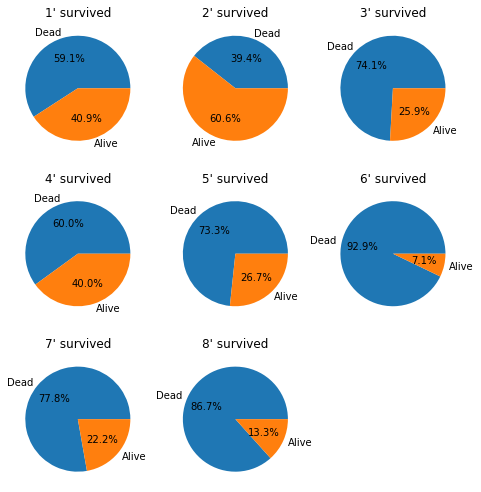

Survived,Dead,Alive
TicketCategory,,
1,136,94
2,91,140
3,272,95
4,6,4
5,11,4
6,13,1
7,7,2
8,13,2


In [13]:
# STON/02. 310282를 ['STON/02.', '310282']로 변경하고 '310282'의 첫 번째 3을 선택

train['TicketCategory'] = train.Ticket.str.split() # 공백으로 분리
train['TicketCategory'] = [i[-1][0] for i in train['TicketCategory']] # 첫번째 숫자 분리
train['TicketCategory'] = train['TicketCategory'].replace(['8', '9', 'L'], '8')
train['TicketCategory'] = pd.factorize(train['TicketCategory'])[0] + 1

c = show_pie_chart(train, 'TicketCategory')
c 

### 정리
컬럼별 생존여부 확인 결과, 여성이고 방 값이 비쌀수록 생존률이 높아지는 것을 알 수 있었다. 

## 전처리
 - 분석할 수 있는 형태로 데이터 변환
   * 데이터 범주화
   * 숫자형 데이터로 변환
 - 생존률과 관계없는 데이터 삭제

(전처리는 train, test 모두 실시)

|기존컬럼|신규컬럼|설명|
|:---:|:---:|:---:|
|Sex|Sex| 성별. female -> 0, male -> 1로 변환|
|Embarked|	Embarked|	탑승항. C -> 0, Q -> 1, S -> 2로 변환
Name|	Title|	이름에서 호칭을 추출. Master -> 0, Miss -> 1, Mr -> 2, Mrs -> 3, Other -> 4로 변환
Age	|AgeCategory|	나이를 qcut으로 8개의 구간으로 분리하여 카테고리화. 결측치는 호칭의 평균값으로 채움
Cabin	|CabinCategory|	방번호를 첫 글자만 따서 카테고리화. 결측치는 N으로 채움
Fare|	FareCategory|	운임을 8개의 구간으로 분리하여 카테고리화. 결측치는 0으로 채움
SibSp, Parch	|Family, IsAlone|	가족으로 합침. 혼자 탑승한 고객 정보 추출
Ticket|	TicketCategory|	티켓 번호의 첫 번째 번호만 추출하여 카테고리화

데이터 분석에 이용한 함수들을 정리해 featue_engineeering 함수를 만들고 훈련용, 검증용 데이터 모두 전처리한다.

In [14]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./gender_submission.csv')

def feature_engineering(df):
    #Sex
    df['Sex'] = df['Sex'].map({'female':0, 'male':1})
    
    #Embarked
    df.Embarked.fillna('S', inplace=True)
    df['Embarked'] = df['Embarked'].map({'C':0, 'Q':1, 'S':2})
    
    # Title
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr','Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Other')
    df['Title'] = df['Title'].replace('Mlle' ,'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
    
    # Age
    meanAge = df[['Title', 'Age']].groupby(['Title']).mean()
    for index, row in meanAge.iterrows():
        nullIndex = df[(df.Title == index) & (df.Age.isnull())].index
        df.loc[nullIndex, 'Age'] = row[0]
        
    df['AgeCategory'] = pd.qcut(df.Age, 8, labels = range(1,9))
    df.AgeCategory = df.AgeCategory.astype(int)
    
    # Cabin
    df.Cabin.fillna('N', inplace = True)
    df['CabinCategory'] = df['Cabin'].str.slice(start=0, stop=1)
    df['CabinCategory'] = df['CabinCategory'].map({'N':0, 'C':1, 'B':2, 'D':3, 'E':4, 'A':5, 'F':6, 'G':7, 'T':8})
    
    # Fare
    df.Fare.fillna(0, inplace = True)
    df['FareCategory'] = pd.qcut(df.Fare, 8, labels = range(1,9))
    df.FareCategory = df.FareCategory.astype(int)
    
    #Sibsp, Parch
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    df.loc[df['Family'] > 4, 'Family'] = 5
    
    df['IsAlone'] = 1 
    df.loc[df['Family'] > 1, 'IsAlone'] = 0
    
    # Ticket
    df['TicketCategory'] = df.Ticket.str.split()
    df['TicketCategory'] = [i[-1][0] for i in df['TicketCategory']]
    df['TicketCategory'] = df['TicketCategory'].replace(['8','9','L'], '8')
    df['TicketCategory'] = pd.factorize(df['TicketCategory'])[0] + 1
    
    df.drop(['PassengerId', 'Ticket', 'Cabin', 'Fare', 'Name', 'Age', 'SibSp', 'Parch'], axis = 1, inplace = True)
    
    return df

train = feature_engineering(train)
test = feature_engineering(test)

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Sex             891 non-null    int64
 3   Embarked        891 non-null    int64
 4   Title           891 non-null    int64
 5   AgeCategory     891 non-null    int64
 6   CabinCategory   891 non-null    int64
 7   FareCategory    891 non-null    int64
 8   Family          891 non-null    int64
 9   IsAlone         891 non-null    int64
 10  TicketCategory  891 non-null    int64
dtypes: int64(11)
memory usage: 76.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Pclass          418 non-null    int64
 1   Sex             418 non-null    int64
 2   Embarked      

> 전처리 후 분석에 사용할 데이터만 남고 나머지는 없어진 것을 확인할 수 있다.

## 머신러닝
 - 적합한 분석 알고리즘 선택
 - 알고리즘 파라미터 최적화

> 타이타닉 생존자 예측은 훈련용 데이터에 정답이 있는 지도 학습입니다. 따라서 전처리가 끝난 데이터를 특성과 정답으로 분리한다.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Pcalss, Sex, Embarkde, Title, AgeCategory, CabinCategory, FareCategory, Family, IsAlone, TicketCategoty
data = train.drop('Survived', axis =1).values
# Survived
target = train['Survived'].values

data는 특성(featrue)이 되고, traget은 정답(Label)이 된다. 
* data : Pcalss, Sex, Embarkde, Title, AgeCateogory, CabinCategory, FareCategory, Family, IsAlone, TicketCategory 
* target : Survived

이제 data를 이용해 Survived를 예측한 결과를 target과 비교해 정확도 판단해본다.

In [19]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Pclass, Sex, Embarked, Title, AgeCategory, CabinCategory, FareCategory, Family, IsAlone, TicketCategory 
data = train.drop('Survived', axis=1).values
# Survived
target = train['Survived'].values

### 훈련용 데이터 분리
---
data와 target을 분리한 다음 훈련용(train.csv)데이터를 다시 훈련용과 검증용으로 분리한다.<br>
시험용(test.csv) 데이터는 생존여부가 없기에 모델의 정확도를 확인할 수 없기 때문. <br>
훈련용 데이터를 (훈련용)6 : (검증용)4 비율로 분리해 훈련용 데이터로 모델을 생성하고 검증용 데이터로 모델의 정확도 검증한다.

<br>
* 데이터의 분리는 scikit-learn에서 제공하는 train_test_split 함수를 이용해 간단하게 처리할 수 있다.

In [20]:
# test_size : 분리 비율 설정.
# stratify : 분리 기준이 될 데이터
# random_state : 랜덤seed

# x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size = 0.4, stratify = target, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)


* 훈련용 
 * x_train : data값
 * y_train : target값 (Survived)

* 검증용
 * x_valid : data 값
 * y_valid : target값 (Survived)

### 랜덤 포레스트 검증 #1
---
여러 가지 알고리즘 중에서 타이타닉 문제에서 가장 성능이 잘 나오는 랜덤 포레스트 알고리즘을 이용해 데이터 검증 실시

아래와 같이 기본적인 파라미터 설정을 통해 83%의 생존률 확인 가능

In [25]:
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=5, oob_score=True, random_state=10)
# rf.fit(x_train, y_train)

rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, oob_score=True, random_state=10)
rf.fit(x_train, y_train)
prediction=rf.predict(x_valid)


length = y_valid.shape[0]
accuracy = accuracy_score(prediction, y_valid)

print(f'총 {length}명 중 {accuracy * 100:.3f}% 정확도록 생존 맞춤')

총 357명 중 82.913% 정확도록 생존 맞춤


In [22]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Pclass, Sex, Embarked, Title, AgeCategory, CabinCategory, FareCategory, Family, IsAlone, TicketCategory 
data = train.drop('Survived', axis=1).values
# Survived
target = train['Survived'].values

# test_size: 분리 비율 설정. 
# stratify: 분리 기준이 될 데이터 
# random_state: 랜덤 seed
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, oob_score=True, random_state=10)
rf.fit(x_train, y_train)
prediction = rf.predict(x_valid)

length = y_valid.shape[0]
accuracy = accuracy_score(prediction, y_valid)
print(f'총 {length}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')

# 결과 

총 357명 중 82.913% 정확도로 생존을 맞춤


### 랜덤포레스트 검증 #2
---
여러 가지 파라미터를 이용해 종합적인 검증을 하고 싶을 때는 <b>GridSearchCV</b>와 <b>StratifiedKFold</b>를 이용한다.<br>

아래와 같이 <b>RF_paramgrid</b>와 같이 딕셔너리 형으로 전달할 여러가지 파라미터값을 설정하고 이 값을 이용해 전달하면 동시에 여러번 테스트를 진행하고, 최적의 옵션 값을 확인할 수 있다. 
(많은 옵션을 설정할수록 처리 횟수가 많아지고 처리 시간이 오래 걸리게 된다.)<br>

아래와 같은 경우 <b>Done 8960 out of 8960 | elapsed: 25.1min finished</b>와 같이 총 8,960번의 테스트를 거치게 되고 25분이 걸렸다. PC 성능에 따라 적당한 옵션을 선택하는 것이 중요하다


In [37]:
RF_classifier = RandomForestClassifier()

RF_paramgrid = {
    'max_depth' : [6, 8, 10, 15],
    'n_estimators': [50, 100, 300, 500, 700, 800, 900],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 7, 15, 30],
    'min_samples_leaf': [1, 15, 30, 60],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
    }

k_fold = StratifiedKFold(n_splits=5)
RF_classifiergrid = GridSearchCV(RF_classifier, param_grid = RF_paramgrid, cv=k_fold, scoring="accuracy", n_jobs= -1, verbose=1)

RF_classifiergrid.fit(x_train, y_train)

rf = RF_classifiergrid.best_estimator_

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 8960 out of 8960 | elapsed: 12.8min finished


In [50]:
# Best Score
print(RF_classifiergrid.best_score_) #0.835178980779404

# Best Parameter
print(RF_classifiergrid.best_params_) 
# {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 50}

# Best Model
print(RF_classifiergrid.best_estimator_)
# RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=7,n_estimators=50)

0.835178980779404
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 50}
RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=7,
                       n_estimators=50)


"\nRandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=7,\n                       n_estimators=50)\n"

### 예측 모델에 영향을 미친 특성 확인
---
예측 모델의 <b>feature_importances_</b>를 이용해 생존률에 영향을 미친 정보를 확인할 수 있다.

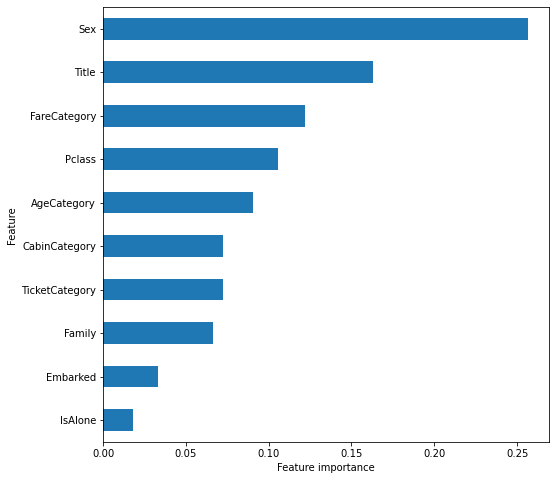

In [47]:
import matplotlib.pyplot as plt
from pandas import Series

feature_importance = rf.feature_importances_
fi = Series(feature_importance, index = train.drop(['Survived'], axis = 1).columns)

plt.figure(figsize=(8,8))
fi.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### 알고리즘 적용
---
전처리가 끝난 데이터에 예측 모델 알고리즘을 적용하는 방법을 알아보겠습니다. 지도 학습에 사용하는 몇 가지 알고리즘을 적용하기 위해 <b>ml_fit</b> 함수를 선언하고, 예측 모델을 기본 파라미터로 생성하여 생존률을 알아보겠습니다.

In [59]:
# 지도학습 모델 import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# data 분리
data=train.drop('Survived', axis=1).values
target - train['Survived'].values
x_train, y_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

# 모델 적용 함수
def ml_fit(model):
    model.fit(x_train, y_train)
    prediction =  model.predict(x_valid)
    accuracy = accuracy_score(prediction, y_valid)
    print(model)
    print(f'총 {y_valid.shape[0]}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')
    return model


In [61]:
# 기본 설정으로만 테스트
model = ml_fit(RandomForestClassifier(n_estimators=100))
model = ml_fit(LogisticRegression(solver='lbfgs'))
model = ml_fit(SVC(gamma='scale'))
model = ml_fit(KNeighborsClassifier())
model = ml_fit(GaussianNB())
model = ml_fit(DecisionTreeClassifier())

RandomForestClassifier()
총 357명 중 80.112% 정확도로 생존을 맞춤
LogisticRegression()
총 357명 중 79.832% 정확도로 생존을 맞춤
SVC()
총 357명 중 81.513% 정확도로 생존을 맞춤
KNeighborsClassifier()
총 357명 중 75.910% 정확도로 생존을 맞춤
GaussianNB()
총 357명 중 73.389% 정확도로 생존을 맞춤
DecisionTreeClassifier()
총 357명 중 75.910% 정확도로 생존을 맞춤


기본 설정으로 테스트한 알고리즘의 정확도는 아래와 같다. 
<br>

|알고리즘|정확도|
|:---:|:---:|
|RandomForestClassifier|80.112%|
|LogisticsRegression|79.832%|
|SVC|81.513%|
|KNeighborsClassifier|75.910%|
|GausianNB|73.389%|
|DecisionTreeClassifier|75.910%|


설정 변경 후 테스트
---
- 다음과 같이 설정을 변경후 테스트를 하면 이전에 80.112 -> 82.913% 상승
- 파라미터 최적화를 통해 알고리즘의 정확도 향상 가능

In [64]:
model = ml_fit(RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=5,oob_score=True, random_state=10))

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50,
                       oob_score=True, random_state=10)
총 357명 중 82.913% 정확도로 생존을 맞춤


## 제출
---
완성한 모델에 시험용 데이터(test.csv)를 전달해 시험용 데이터의 생존 여부 예측한다. <B>prediction</B>을 확인하면 생존 여부가 1,0으로 표현되는 것을 알 수 있다.

In [70]:
# 시험용 데이터 예측
prediction = rf.predict(test)
prediction 

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

### 제출용 데이터 생성

제출용 데이터 csv를 생성하는 두 가지 방법 확인.

### submission 파일 이용법
___
submission 파일을 읽어 PassengerId, Survived 정보를 가져오고, 검증용(test) 데이터를 분석한 결과인 prediction을 survived값에 대치해 제출용 파일 생성

In [73]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = prediction
submission.to_csv('sub_210607.csv', index=False)

### 데이터 프레임 생성 방법
___
다른 방법은 test데이터와 prediction값을 이용해 데이터 프레임을 생성하는 방법이다.

In [85]:
test = pd.read_csv('test.csv')
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": prediction
})


submission.to_csv('submission_2.csv', index = False)